In [1]:
# Import Library

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

In [2]:
# Input Data

q_list = [100, 250, 400, 550, 700, 850]
pwf_list = [1300, 1200, 1100, 1000, 850, 700]       # psia
p_res = 1400                                        # psia
whp = 500                                           # psia
gradient = 0.12                                     # psi/ft
depth = 8000                                        # ft

In [ ]:
# Define Function (Log-log Regression)

df = pd.DataFrame({
    'q_stb': q_list,
    'pwf_psig': pwf_list
})
df['delta^2'] = p_res**2 - df['pwf_psig']**2
df['log_q'] = np.log10(df['q_stb'])
df['log_delta2'] = np.log10(df['delta^2'])

fit = np.polyfit(df['log_q'], df['log_delta2'], 1)
poly_func = np.poly1d(fit)      # optional: use this if plotting log-log regression line
n = 1 / fit[0]
c = q_list[0] / (p_res**2 - pwf_list[0]**2)**n

In [4]:
# Define IPR & VLP

pwf_range = np.arange(100, p_res, 10)
q_ipr = [c * (p_res**2 - pwf**2)**n for pwf in pwf_range]

def vlp_model(q):
    return whp + gradient * depth + 0.002 * q**1.5

q_vlp = np.linspace(0, max(q_ipr)*1.1, 100)
p_vlp = vlp_model(q_vlp)

In [5]:
# Intersection of IPR & VLP

ipr_func = interp1d(q_ipr, pwf_range, fill_value="extrapolate")
vlp_func = interp1d(q_vlp, p_vlp, fill_value="extrapolate")

q_common = np.linspace(0, min(max(q_ipr), max(q_vlp)), 200)
p_ipr_common = ipr_func(q_common)
p_vlp_common = vlp_func(q_common)
delta_P = np.abs(p_ipr_common - p_vlp_common)
idx_min = np.argmin(delta_P)
q_intersect = q_common[idx_min]
p_intersect = p_ipr_common[idx_min]

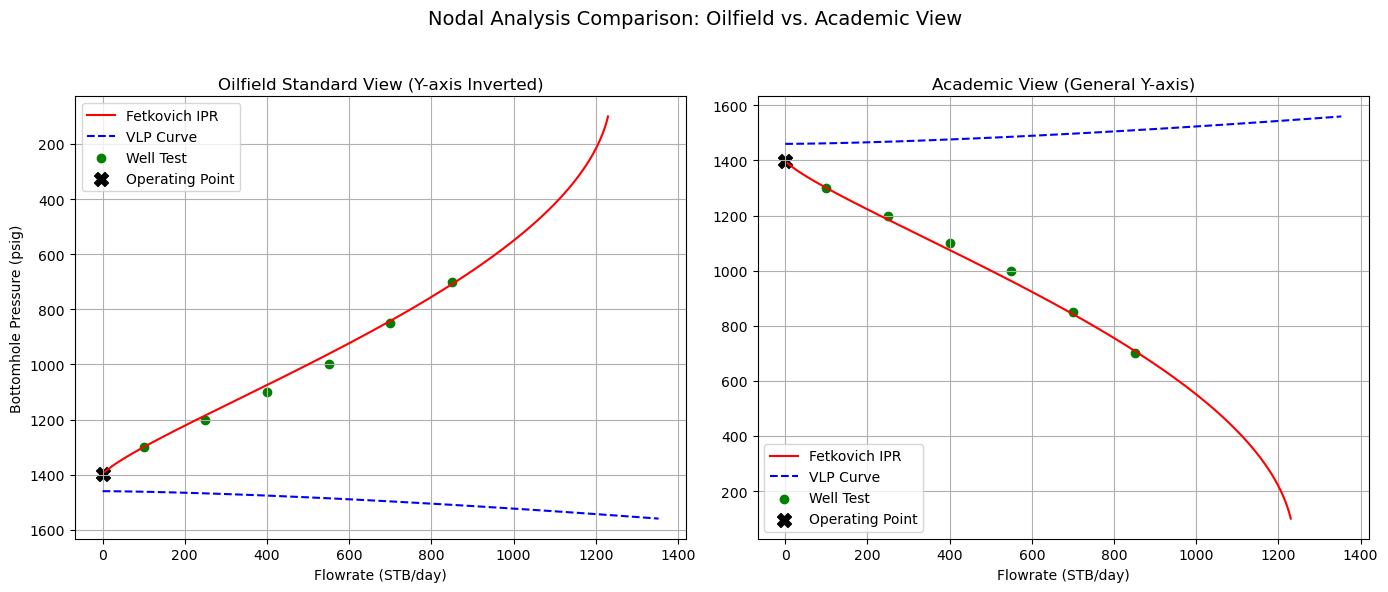

✅ n = 1.2693
✅ c = 1.2766e-05
📍 Operating Point: Q = 0.0 STB/day | Pwf = 1397.1 psig


In [6]:
# Plot of IPR vs VLP (Oilfield Standard and Academic View)

fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True)

# (Left) Inverted Y-axis (Oilfield view)
axes[0].plot(q_ipr, pwf_range, label='Fetkovich IPR', color='red')
axes[0].plot(q_vlp, p_vlp, label='VLP Curve', color='blue', linestyle='--')
axes[0].scatter(q_list, pwf_list, label='Well Test', color='green')
axes[0].scatter(q_intersect, p_intersect, color='black', marker='X', s=100, label='Operating Point')
axes[0].invert_yaxis()
axes[0].set_title('Oilfield Standard View (Y-axis Inverted)')
axes[0].set_xlabel('Flowrate (STB/day)'), axes[0].set_ylabel('Bottomhole Pressure (psig)')
axes[0].legend()
axes[0].grid(True)

# (Right) Academic View
axes[1].plot(q_ipr, pwf_range, label='Fetkovich IPR', color='red')
axes[1].plot(q_vlp, p_vlp, label='VLP Curve', color='blue', linestyle='--')
axes[1].scatter(q_list, pwf_list, label='Well Test', color='green')
axes[1].scatter(q_intersect, p_intersect, color='black', marker='X', s=100, label='Operating Point')
axes[1].set_title('Academic View (General Y-axis)')
axes[1].set_xlabel('Flowrate (STB/day)')
axes[1].legend()
axes[1].grid(True)

plt.suptitle('Nodal Analysis Comparison: Oilfield vs. Academic View', fontsize=14)
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

print(f"✅ n = {n:.4f}")
print(f"✅ c = {c:.4e}")
print(f"📍 Operating Point: Q = {q_intersect:.1f} STB/day | Pwf = {p_intersect:.1f} psig")